In [1]:
import sys
sys.path.insert(0, '..')

import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from intransparent import (
    combine_brands,
    ingest_reports_per_platform,
    REPORTS_PER_PLATFORM,
    show,
    wide_ncmec_reports,
)
import intransparent.meta as meta


_TDB_URL = (
'https://www.thedailybeast.com/facebook-a-hotbed-of-child-sexual-abuse-material-'
'with-203-million-reports-far-more-than-pornhub'
)


data = ingest_reports_per_platform(REPORTS_PER_PLATFORM)

show(f"<h1>Meta's Insufficient and Buggy Transparency</h1>")
show(f'<h2>Meta is a “<a href="{_TDB_URL}">Hotbed of CSAM</a>”</h2>')
show(
    """
    Meta is responsible for the vast majority of CyberTipline reports and also
    pieces. Yet, its transparency disclosures aren't very transparent.
    <ul>
    <li>Meta does not disclose the number of CSAM reports made to NCMEC, only
    pieces.</li>
    <li>Meta is the only social media firm to round its counts</li>
    <li>Meta makes no transparency disclosures for WhatsApp. Yet, it does file
    CSAM reports for the app. This became apparent when NCMEC started
    distinguishing between Facebook, Instagram, and WhatsApp for its 2021 transparency
    disclosures.</li>
    </ul>
    Furthermore, see below.
    """
)

ncmec = wide_ncmec_reports(data, drop_brands=False)
meta_reports = meta.csam_reports(ncmec)
show(
    meta_reports,
    caption="Meta's Share of CSAM Reports",
    highlight_columns=['%', '% Meta'],
    margin_bottom=0,
)

,Total,%,Meta,Facebook,Instagram,WhatsApp,% Meta
period,,,,,,,
2019,"16,836,694",94.3,"15,884,511",⋯,⋯,⋯,⋯
2020,"21,447,786",94.7,"20,307,216",⋯,⋯,⋯,⋯
2021,"29,157,083",92.2,"26,885,302","22,118,952","3,393,654","1,372,696",5.11
2022,"31,802,525",85.5,"27,190,665","21,165,208","5,007,902","1,017,555",3.74


In [2]:
# (1) Determine number of reports NCMEC received from Meta per year
yearly_reports = ncmec['Meta'].pipe(lambda s: s.groupby(s.index.year)).sum()

# (2) Determine number of pieces detected by Meta per quarter. This is an
# approximation only because neither of the two original metrics is exactly the
# same as CSAM.
quarterly_pieces = (
    combine_brands(data)['Meta'][[
        'pieces (Child Nudity & Sexual Exploitation)',
        'pieces (Child Endangerment: Sexual Exploitation)'
    ]]
    .sum(axis=1)
)
quarterly_pieces.name = 'pieces'

# (3) Convert to pieces per year. Don't forget to drop incomplete years!
yearly_pieces = (
    quarterly_pieces
    .pipe(lambda df: df.groupby(df.index.year))
    .sum()
    .loc[2019:2022]
)

# (4) Show the relationship between pieces and reports.
pieces_v_reports = pd.DataFrame({
    'pieces': yearly_pieces,
    'π': yearly_pieces / yearly_reports,
    'reports': yearly_reports,
})

show('<h2>Pieces vs Reports</h2>')
show(
    """
    Neither Meta nor NCMEC discloses both piece and report counts in their
    transparency reports. Hence we cannot validate the counts. But we can still
    whether their ratios are plausible. The table below shows that they are.
    """
)
show(
    pieces_v_reports,
    caption='Pieces (Meta) v Reports (NCMEC)',
    emit_latex=True,
)

,pieces,π,reports
period,,,
2019,"39,368,400",2.48,"15,884,511"
2020,"38,890,800",1.92,"20,307,216"
2021,"78,012,400",2.90,"26,885,302"
2022,"105,800,000",3.89,"27,190,665"


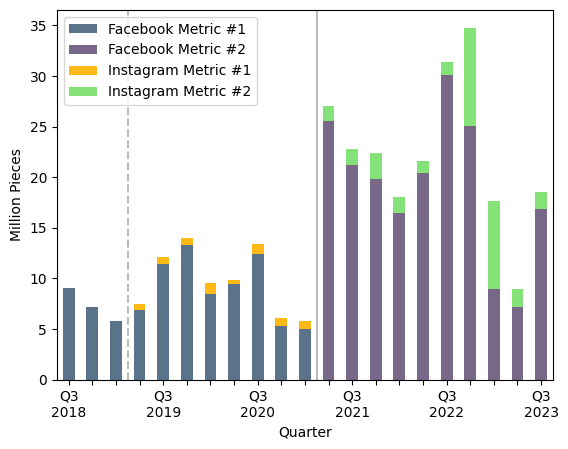

In [46]:
COLUMNS = [
    'pieces (Child Nudity & Sexual Exploitation)',
    'pieces (Child Endangerment: Sexual Exploitation)',
]

pieces_fb = data.disclosures['Facebook'][COLUMNS].rename(columns={
    'pieces (Child Nudity & Sexual Exploitation)': 'Facebook Metric #1',
    'pieces (Child Endangerment: Sexual Exploitation)': 'Facebook Metric #2',
})
pieces_insta = data.disclosures['Instagram'][COLUMNS].rename(columns={
    'pieces (Child Nudity & Sexual Exploitation)': 'Instagram Metric #1',
    'pieces (Child Endangerment: Sexual Exploitation)': 'Instagram Metric #2',
})

pieces = pd.concat([pieces_fb, pieces_insta], axis=1).sort_index()

ax = pieces.plot.bar(
    stacked=True,
    color = ('#5a738a', '#776887','#fdba17','#84e278', '#776887', '#825aa9'),
    # color = ('#8080d0', '#7070c0', '#ff8060', '#ff7050'),
    # color = ('#4743a1', '#d1448f', '#ff6852', '#fac000'),
    # color = ('#4b4fbd', '#794cbd', '#363987', '#65409e'),
    # color = ('#a6c3d1', '#cbb3d0', '#364c80', '#563680'),
    # color = ("#b1d9fa", "#7ca7c9", "#47789a", "#004c6d"),
    # color=("#ede15b", "#edbf33", "#ef9b20", "#ea5545"),
)
ax.set_xlabel('Quarter')
ax.set_ylabel('Million Pieces')
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))

plt.draw()

LABEL_PATTERN = re.compile(r'(\d{4})(Q\d)')
labels = []

for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % 4 == 0:
        label.set_text(LABEL_PATTERN.sub('\g<2>\n\g<1>', label.get_text()))
        label.set_rotation(0)
    else:
        label.set_visible(False)
    labels.append(label)

ax.xaxis.set_ticklabels(labels)
ax.axvline(2.5, color='#bbb', linestyle='dashed')  # after Q1 2019
ax.axvline(10.5, color='#bbb')  # after Q1 2021

ax.get_figure().savefig(
    '../figure/meta-pieces-per-quarter.svg',
    format='svg',
    bbox_inches='tight'
)


,pieces,Δ%
period,,
2018Q3,"9,000,000",⋯
2018Q4,"7,200,000",⋯
2019Q1,"5,800,000",⋯
2019Q2,"7,426,200",⋯
2019Q3,"12,155,800",35.06
2019Q4,"13,986,400",94.26
2020Q1,"9,500,000",63.79
2020Q2,"9,881,400",33.06
2020Q3,"13,400,000",10.24


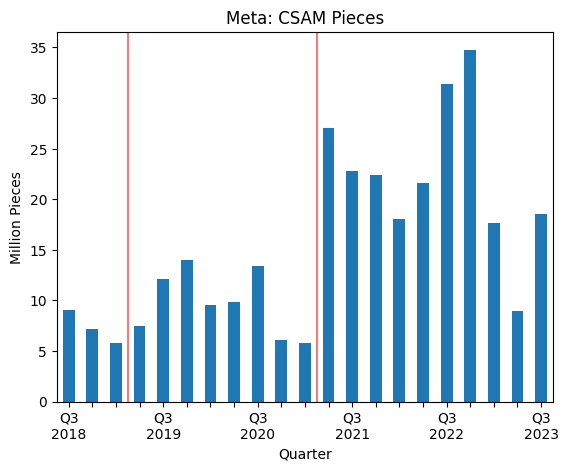

In [6]:
# Now, we explore year-over-year growth for quarterly piece counts.
yoy_change = (
    quarterly_pieces
    .to_frame()
    .assign(**{'Δ%': lambda df: df['pieces'].pct_change(periods=4) * 100})
)

show('<h2>Quarterly Statistics</h2>')
show(yoy_change, caption='Pieces per Quarter<br>Year-Over-Year Change')

ax = yoy_change['pieces'].plot.bar()
ax.set_title('Facebook & Instagram: CSE Pieces')
ax.set_xlabel('Quarter')
ax.set_ylabel('Million Pieces')
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))

plt.draw()

LABEL_PATTERN = re.compile(r'(\d{4})(Q\d)')
labels = []

for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % 4 == 0:
        label.set_text(LABEL_PATTERN.sub('\g<2>\n\g<1>', label.get_text()))
        label.set_rotation(0)
    else:
        label.set_visible(False)
    labels.append(label)

ax.xaxis.set_ticklabels(labels)
ax.axvline(2.5, color='#ff000088')  # after Q1 2019
ax.axvline(10.5, color='#ff000088')  # after Q1 2021


In [4]:
show(f'<h2>Meta Rewrites History</h2>')
show(
    """
    While testing an update to my data analysis code, I discovered that Meta had
    changed seemingly arbitrary entries for previously disclosed transparency
    statistics. This section tracks the extent of these unacknowledged and
    unexplained changes by comparing Meta's CSV files quarter over quarter.
    """
)

meta_disclosures = meta.read_all('../data')
meta_differences = meta.diff_all(meta_disclosures)

for p1, delta in meta_differences.items():
    p2 = p1 + 1

    show(f'<h2>Δ(Q{p2.quarter}-{p2.year} / Q{p1.quarter}-{p1.year})</h2>')
    show(meta.age_of_divergence(delta), margin_bottom=0)
    show(meta.descriptors_of_divergence(delta))

,divergent
period,
2020Q1,6
2020Q2,8
2020Q3,14
2020Q4,15
2021Q1,13
2021Q2,15


,divergent
period,
2021Q2,6
2021Q3,21


,divergent
period,
2020Q2,86
2021Q4,10


,divergent
period,
2020Q3,79
2020Q4,2
2021Q1,3
2021Q2,4
2021Q4,1
2022Q1,13


,divergent
period,
2020Q4,77
2021Q1,3
2021Q2,4
2022Q2,29


,divergent
period,
2020Q2,67
2020Q3,60
2020Q4,58
2022Q3,18


,divergent
period,
2022Q4,18


,divergent
period,


,divergent
period,


In [5]:
show(f'<h3>Quarterly rate of divergence</h3>')
show(meta.rate_of_divergence(meta_disclosures, meta_differences), emit_latex=True)
show(
    """
    For each quarter, the abvove table shows the number of entries in that
    quarter's data that are different from the previous quarter's disclosure
    divided by the total number of entries from the previous quarter. In other
    words, newly added data points do not figure into this rate.
    """
)

,period,changed,total,rate_of_divergence
0,2021Q3,71,"1,904",3.729
1,2021Q4,27,"2,192",1.232
2,2022Q1,96,"2,339",4.104
3,2022Q2,102,"2,486",4.103
4,2022Q3,113,"2,633",4.292
5,2022Q4,203,"2,780",7.302
6,2023Q1,18,"2,927",0.615
7,2023Q2,0,"3,074",0.000
8,2023Q3,0,"3,221",0.000
